### Estimating reproducing and aestivating sizes for Lehmann's dataset
#### version 2, with 6 months per season
via ABC?

Now we have calculated summary statistics, and estimated some Ne for the dataset. Next is to apply what we have learnt from modelling and try to estimate reproducing and aestivating sizes. In the modelling notebook, we understood how aestivation alters alelle frequency over time in a different way from seasonal Ne. Mosquitoes re-emerge at the beginning of the wet season, dampens the changes (and variance). As a result, if our temporal samples cover such time point, then the temporal F will be smaller than the sum of shorter term F. 

We now hope to use the same model for parameter estimation. In our simplest aestivation model we have 3 parameters (wet + dry reproducing and aestivating sizes). We could use the same simulator, but it is slow. Let us rewrite a simplified (but a lot quicker) version for it. How simple is this? Previously our individual-based simulator simulate haplotypes for all inviduals in the population. What if we do not need to know the exact genotype configuration of all individuals? What if we are only interested in the allele frequency?. By omitting individual information save a lot of time (provided that you know how to write it). The simplified version, however, does not provide us signals such as LD or clustering. I also make other minor adjustments, such as making it 6 generations per season. 

Then we read in the Lehmann's dataset, and repeat some simple calculations/countings. For example, the temporal separation between samples, and the effective sample size per locus (per population). We may need some of our previously-defined functions, such as those regarding the calculation of temporal F. 

In [1]:
require(compiler)
require(doParallel)
require(inline)

Loading required package: compiler
Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: inline


In [2]:
# A SIMPLIFIED SIMULATOR OF ALLELE FREQ FOR AESTIVATION
# THREE PARAMETER MODEL
# [2] IS THE BEGINNING OF RS, SAY, MAY
quick_aestivation_sim<-function(N_r=5000, N_d=500, N_a=1000, t_r=6, t_d=6, years=5, K=500, starting_month=6)
{
    # EXPAND BREEDING SIZES
    rep_N<-rep(c(N_r-N_a, rep(N_r, t_r-1), rep(N_d, t_d)), years)
    rep_N[1]<-N_r
    t<-length(rep_N)
    denom_N<-rep(c(rep(N_r, t_r), rep(N_d, t_d)), years)
    # TRANSITION, -1 MEANS FROM DS TO RS. +1 RS TO DS
    aes<-rep(c(rep(0, t_r), 1, rep(0, t_d-1)), years)
    aes_return<-rep(c(1, rep(0, t_r+t_d-1)), years)
    aes_return[1]<-0
    # INITIAL ALLELE FREQ OF THE TWO COMPARTMENTS
    p_rep<-matrix(nc=t+1, nr=K)
    p_rep[,1]<-runif(K, 0.2, 0.8)
    p_aes<-rep(0, K)
    for (i in 1:t)
    {
        p_rep[,i+1]<-(rbinom(K, size=2*rep_N[i], prob=p_rep[,i])+aes_return[i]*p_aes)/(2*denom_N[i])
        if (aes[i]==1)
        {
            p_aes<-rbinom(K, size=2*N_a, prob=p_rep[,i])
        }
    }
    return(p_rep)
}
quick_aestivation_sim<-cmpfun(quick_aestivation_sim, 3)
#
quick_aestivation_sim_month<-function(t_r=6, t_d=6, years=5, starting_month=6)
{
    t<-(t_r+t_d)*years
    # RETURN THE MONTHS AND SEASON
    month<-(starting_month:(starting_month+t))%%12
    month[month==0]<-12
    month<-c(NA, month)
    season<-c(NA, rep(c(rep('rainy', t_r), rep('dry', t_d)), years))
    return(list(month=month, season=season))
}
#
h_mean<-function(x) {1/mean(1/x, na.rm=T)}

In [3]:
# ANOTHER VERSION. HOPEFULLY FASTER
body<-"
	GetRNGstate();
	double *h_rep_N=REAL(rep_N); double *h_denom_N=REAL(denom_N);
	int *h_aes=INTEGER(aes); double *h_aes_return=REAL(aes_return);
	int h_K=asInteger(K); double h_N_a=asReal(N_a);
	int t=LENGTH(rep_N);
	// THE ALLELE FREQ MATRIX FOR BREEDING
	SEXP p_rep=PROTECT(allocMatrix(REALSXP, h_K, t+1));
	double *h_p_rep=REAL(p_rep);
	// VECTOR TO AESTIVATING
	SEXP p_aes=PROTECT(allocVector(REALSXP, h_K));
	double *h_p_aes=REAL(p_aes);
	// INITIALISE
	for (int i=0; i<h_K; i++)
	{
		h_p_rep[i]=runif(0.2, 0.8);
		h_p_aes[i]=0;
	}
	// PROPAGATE
	int offset=0; int offset_parent=0;
	for (int i=0; i<t; i++)
	{
		offset=(i+1)*h_K; offset_parent=i*h_K;
		for (int j=0; j<h_K; j++)
		{
			h_p_rep[offset+j]=(rbinom(2*h_rep_N[i], h_p_rep[offset_parent+j])+h_aes_return[i]*h_p_aes[j])/(2*h_denom_N[i]);
			if (h_aes[i]==1)
			{
				h_p_aes[j]=rbinom(2*h_N_a, h_p_rep[offset_parent+j]);
			}
		}
	}
	PutRNGstate();
	UNPROTECT(2);
	return p_rep;
"
includes<-"
#include <R.h>
#include <Rdefines.h>
#include <Rinternals.h>
#include <Rmath.h>
"
quick_aestivation_sim_c<-cfunction(sig=c(rep_N='array', denom_N='array', aes='array', 
                                         aes_return='array', N_a='numeric', K='integer'), 
                          body=body, includes=includes, 
                          language='C', convention='.Call')

quick_aestivation_sim2<-function(N_r=5000, N_d=500, N_a=1000, t_r=6, t_d=6, years=5, K=500, starting_month=6)
{
    # EXPAND BREEDING SIZES
    rep_N<-rep(c(N_r-N_a, rep(N_r, t_r-1), rep(N_d, t_d)), years)
    rep_N[1]<-N_r
    t<-length(rep_N)
    denom_N<-rep(c(rep(N_r, t_r), rep(N_d, t_d)), years)
    # TRANSITION, -1 MEANS FROM DS TO RS. +1 RS TO DS
    aes<-rep(c(rep(0, t_r), 1, rep(0, t_d-1)), years)
    aes_return<-rep(c(1, rep(0, t_r+t_d-1)), years)
    aes_return[1]<-0
    # RUN
    p_rep<-quick_aestivation_sim_c(rep_N, denom_N, as.integer(aes), aes_return, N_a, as.integer(K))
    return(p_rep)
}
quick_aestivation_sim2<-cmpfun(quick_aestivation_sim2, 3)

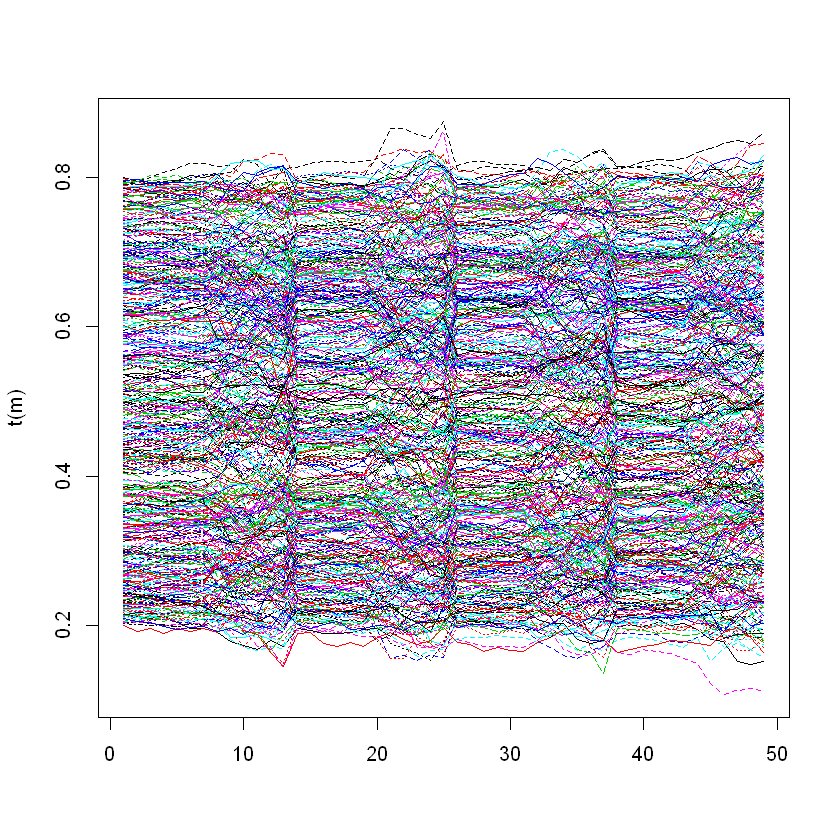

In [4]:
# TEST
m<-quick_aestivation_sim2(N_r=5000, N_d=500, N_a=4500, years=4)
matplot(t(m), type='l')
abline(v=c(52, 52+9, 52+14), col='grey', lty=2)

[1] 505 742

[1] "PoD"         "MosID"       "Sex"         "CollDate"    "X2L10328509"
[6] "X2L11053982" "X2L11709879" "X2L11960688"

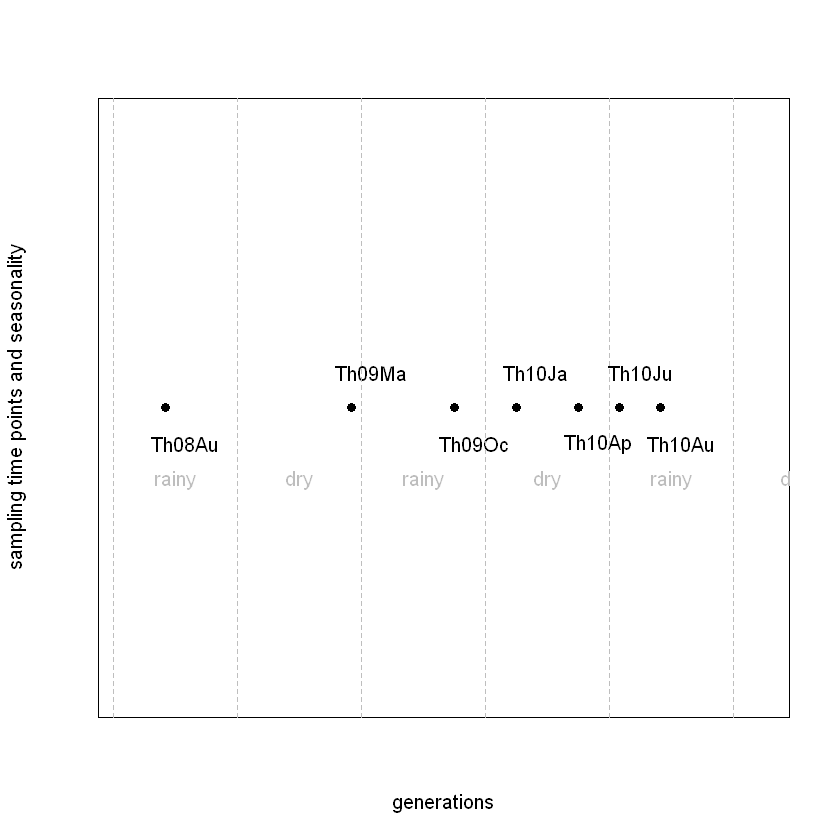

In [5]:
# READ LEHMANN csv 
dat<-read.csv('Lehmann_coded_tinyu.csv', header=T, stringsAsFactors=F)
dim(dat)
names(dat)[1:8]

# THE 7 THIEROLA POPULATIONS IN CHRONOLOGICAL ORDER
PoD<-c('Th08Au', 'Th09Ma', 'Th09Oc', 'Th10Ja', 'Th10Ap', 'Th10Ju', 'Th10Au')

# CREATE A VECTOR TO SHOW THE RELATIVE TIME (IN GENERATIONS) AMONG THESE 7 TIME POINTS
# Th08Au IS CONSIDERED AS THE 0th MONTH OF THE SAMPLE. 09Ma IS MAY, 10Ju IS JUNE
t<-c(0, 9, 14, 17, 20, 22, 24)

# WORK OUT ALL ALLELE FREQ PER POPULATION
# AND ALSO EFFECT SAMPLE SIZE PER LOCUS PER POPULATION
# 7 ROWS, 738 COLUMNS
all_allele_freq<-matrix(nr=length(PoD), nc=ncol(dat)-4)
all_eff_s<-all_allele_freq
for (i in 1:length(PoD))
{
    sample<-dat[dat$PoD==PoD[i], 5:ncol(dat)]
    all_allele_freq[i,]<-apply(sample, 2, function(x) {mean(x, na.rm=T)/2})
    all_eff_s[i,]<-apply(sample, 2, function(x) {sum(!is.na(x))})
}

# PLOT THE SEASONS
plot(y=rep(1, length(t)), x=t+27, 
    xlab='generations', ylab='sampling time points and seasonality', xlim=c(25, 56), pch=16, yaxt='n', xaxt='n')
text(y=1+0.05*(-1)^(1:length(t)), x=t+28, labels=PoD)
temp<-c(6.5, 12.5)
temp<-c(temp, temp+12, temp+24, temp+36, temp+48, temp+60, temp+72, temp+84, temp+96)
abline(v=temp, col='grey', lty=2)
text(y=rep(0.9, length(temp)), x=temp-3, label=rep(c('rainy', 'dry'), length(temp)/2), col='grey')
rm(temp)
# DEC TO MAY ARE DS (LEHMANN ET AL. )

#### Year 1 ABC revisited with 6 months DS

In [16]:
# YEAR 1, Th08Au, Th09Ma, Th09Oc
# EXTRACT THE THREE ALLELE FREQ
p1<-all_allele_freq[1,]
p2<-all_allele_freq[2,]
p3<-all_allele_freq[3,]
# THE THREE EFFECTIVE SAMPLE SIZE PER LOCUS
eff_s1<-all_eff_s[1,]
eff_s2<-all_eff_s[2,]
eff_s3<-all_eff_s[3,]
# OVERALL ALLELE FREQ, WEIGHTED AVERAGE
p<-(p1*eff_s1+p2*eff_s2+p3*eff_s3)/(eff_s1+eff_s2+eff_s3)
# MAF CUTOFF, POOLED, AND NOT FIXED/EXTINCT
temp<-(p>=0.05) & (p<=0.95) & (p1>0) & (p1<1) & (p2>0) & (p2<1) & (p3>0) & (p3<1)
#temp<-(p>=0.05) & (p<=0.95)
K<-sum(temp)
K
# SUBSET
p1<-p1[temp]
p2<-p2[temp]
p3<-p3[temp]
eff_s1<-eff_s1[temp]
eff_s2<-eff_s2[temp]
eff_s3<-eff_s3[temp]
# THE F STATISTIC
obs_F21<-mean((p1-p2)^2/((p1+p2)/2-p1*p2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
obs_F32<-mean((p3-p2)^2/((p3+p2)/2-p3*p2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
obs_F31<-mean((p3-p1)^2/((p3+p1)/2-p3*p1)-0.5/eff_s3-0.5/eff_s1, na.rm=T)
c(obs_F21, obs_F32, obs_F31)

[1] 540

[1] 0.06522689 0.06538426 0.02563223

In [7]:
# NUMBER OF GENERATIONS (FOUR YEARS OF BURN IN = 48, START FROM 3RD GEN OF WET)
t1<-t[1]+28
t2<-t[2]+28
t3<-t[3]+28
c(t1, t2, t3)
# CHECK MONTHS AND SEASONS
temp<-quick_aestivation_sim_month(t_r=6, t_d=6)
temp$season[c(t1, t2, t3)]
temp$month[c(t1, t2, t3)]
rm(temp)

[1] 28 37 42

[1] "rainy" "dry"   "rainy"

[1]  8  5 10

In [8]:
# ABC
cl<-makeCluster(47)
registerDoParallel(cl)
result<-foreach(i=1:200, .combine='rbind', .packages='inline') %dopar%
{
    # BUILD cfunction
    quick_aestivation_sim_c<-cfunction(sig=c(rep_N='array', denom_N='array', aes='array', 
                                         aes_return='array', N_a='numeric', K='integer'), 
                          body=body, includes=includes, 
                          language='C', convention='.Call')
    # BEGIN ABC
    k<-50000
    out<-1000
    prior_d<-round(runif(k, 10, 200))
    prior_r<-round(runif(k, prior_d+2, 5000))
    prior_a<-round(runif(k, 1, prior_r-prior_d))
    temp_result<-matrix(nc=3, nr=k)
    for (j in 1:k)
    {
        # SIM
        temp<-quick_aestivation_sim2(N_r=prior_r[j], N_d=prior_d[j], N_a=prior_a[j], K=K)
        # SAMPLING
        x1<-rbinom(K, size=2*eff_s1, prob=temp[,t1])/(2*eff_s1)
        x2<-rbinom(K, size=2*eff_s2, prob=temp[,t2])/(2*eff_s2)
        x3<-rbinom(K, size=2*eff_s3, prob=temp[,t3])/(2*eff_s3)
        # CALCULATE F
        sim_F21<-mean((x2-x1)^2/((x1+x2)/2-x1*x2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
        sim_F32<-mean((x3-x2)^2/((x3+x2)/2-x3*x2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
        sim_F31<-mean((x3-x1)^2/((x3+x1)/2-x3*x1)-0.5/eff_s1-0.5/eff_s3, na.rm=T)
        temp_result[j,]<-c(sim_F21, sim_F32, sim_F31)
    }
    # CALCULATE DISTANCE
    distance<-sqrt((temp_result[,1]-obs_F21)^2+(temp_result[,2]-obs_F32)^2+(temp_result[,3]-obs_F31)^2)
    temp<-order(distance)[1:out]
    # SHORTLIST
    return(cbind(prior_r[temp], prior_d[temp], prior_a[temp], distance[temp]))
}
stopCluster(cl)
dim(result)

[1] 200000      4

In [9]:
# SAVE ABC RESULTS
save(obs_F21, obs_F32, obs_F31, K, t1, t2, t3, result, file='ABC_ex1_v2.RData')

In [10]:
load('ABC_ex1_v2.RData')

In [11]:
# THEN CALCULATE ANOTHER ROUND OF DISTANCE
temp<-order(result[,4])[1:1000]
posterior_r<-result[temp,1]
posterior_d<-result[temp,2]
posterior_a<-result[temp,3]
max(result[temp,4]) # EPSILON
rm(temp)

[1] 0.01687338

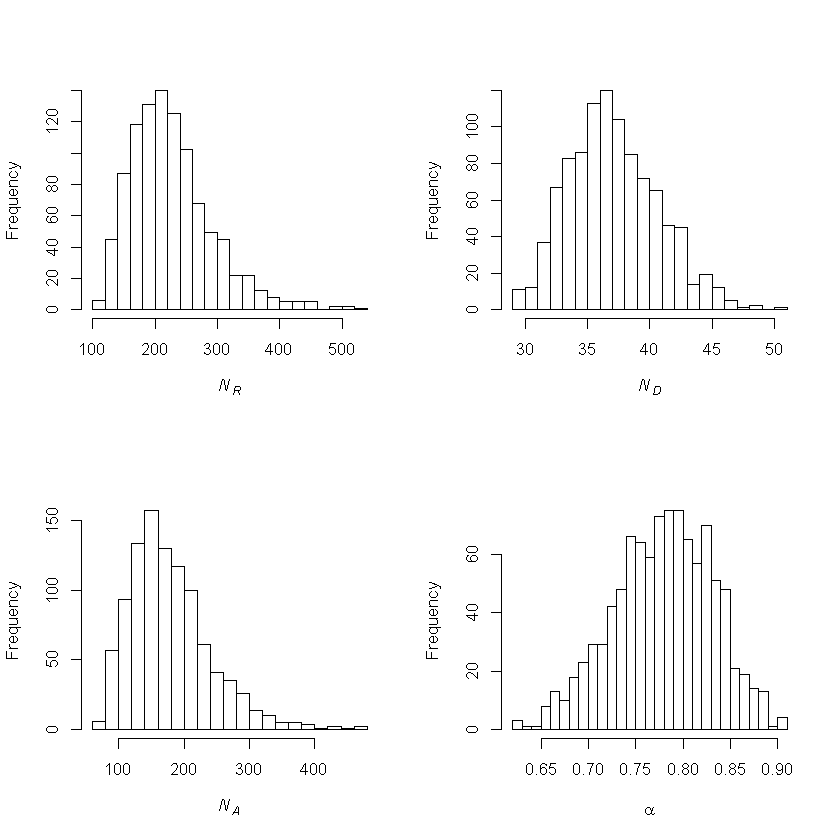

In [12]:
# PLOT POSTERIORS
par(mfrow=c(2,2))
hist(posterior_r, breaks=25, xlab=expression(italic(N['R'])), main='')
hist(posterior_d, breaks=25, xlab=expression(italic(N['D'])), main='')
hist(posterior_a, breaks=25, xlab=expression(italic(N['A'])), main='')
hist(posterior_a/posterior_r, breaks=25, xlab=expression(italic(alpha)), main='')

In [13]:
# SAVE HIGH RES POSTERIOR PLOT
png('fig3_v2.png', height=4800, width=4800, res=300)
par(mfrow=c(2,2), cex=1.5, cex.lab=1.2, cex.axis=1.2, mar=c(5,5,5,5), lwd=3)
hist(posterior_r, breaks=25, xlab=expression(italic(N['R'])), main='')
hist(posterior_d, breaks=25, xlab=expression(italic(N['D'])), main='')
hist(posterior_a, breaks=25, xlab=expression(italic(N['A'])), main='')
hist(posterior_a/posterior_r, breaks=25, xlab=expression(italic(alpha)), main='')
dev.off()

png 
  2

In [14]:
# POSTERIOR STATS
median(posterior_r)
quantile(posterior_r, c(0.025, 0.05, 0.95, 0.975))
median(posterior_d)
quantile(posterior_d, c(0.025, 0.05, 0.95, 0.975))
median(posterior_a)
quantile(posterior_a, c(0.025, 0.05, 0.95, 0.975))
median(posterior_a/posterior_r)
quantile(posterior_a/posterior_r, c(0.025, 0.05, 0.95, 0.975))

[1] 216

2.5%      5%     95%   97.5% 
131.000 140.000 347.200 387.025

[1] 37

2.5%    5%   95% 97.5% 
   32    32    44    45

[1] 167

2.5%     5%    95%  97.5% 
 91.00  98.00 295.10 325.05

[1] 0.7816675

2.5%        5%       95%     97.5% 
0.6691644 0.6882235 0.8618394 0.8742706

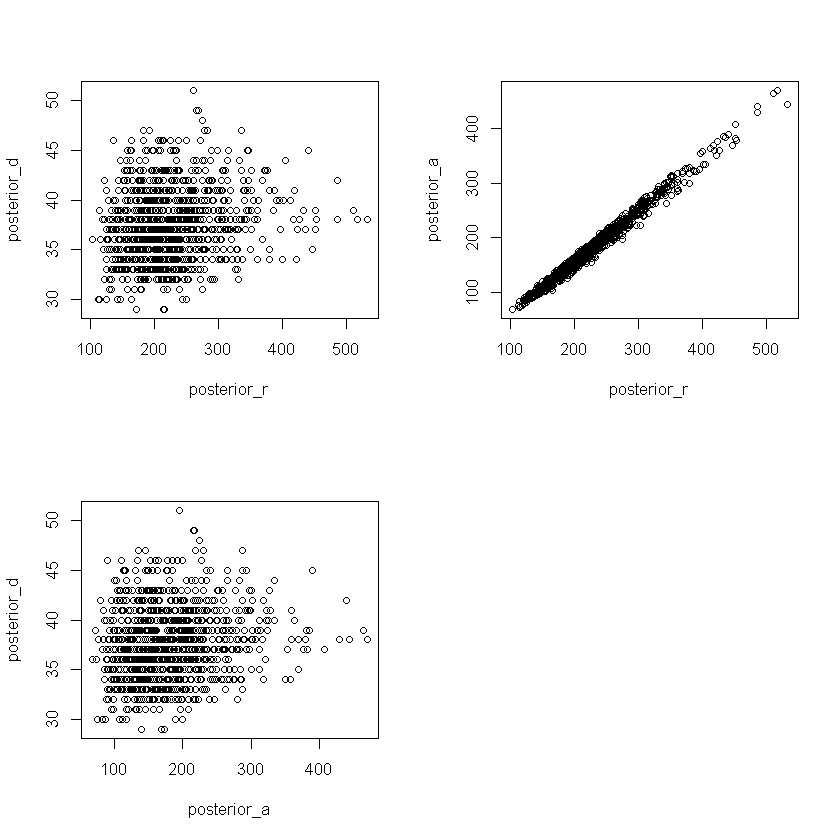

In [15]:
par(mfrow=c(2,2))
plot(posterior_r, posterior_d)
plot(posterior_r, posterior_a)
plot(posterior_a, posterior_d)

#### Example 2
Below is another example, with Th09Oc, Th10Ap, Th10Ju. I found the code above is slow. Although the ABC is run across multiple cores, it takes a lot of time to combine and reutn all 1 million sets of summary statistics. Below is another implementation, that I run 1000 batches of 1000 simulations, and return the first 20 from each batch. Then I calculate another round of distances, and choose the best 1000 as my posterior. The acceptance rate remains at 0.1%, but I do no need to deal with 1 millions elements at the final - many are discarded along the way. 

Another change I make is the prior. This time I sample the prior of the dry size first, then use it as the lower bound for my wet size. This makes the two priors more "uniform". 

In [17]:
# ANOTHER EXAMPLE. Th09Oc, Th10Ap, Th10Ju
# THE OBSERVED F
# EXTRACT THE THREE ALLELE FREQ
p1<-all_allele_freq[3,]
p2<-all_allele_freq[5,]
p3<-all_allele_freq[6,]
# THE THREE EFFECTIVE SAMPLE SIZE PER LOCUS
eff_s1<-all_eff_s[3,]
eff_s2<-all_eff_s[5,]
eff_s3<-all_eff_s[6,]
# OVERALL ALLELE FREQ, WEIGHTED AVERAGE
p<-(p1*eff_s1+p2*eff_s2+p3*eff_s3)/(eff_s1+eff_s2+eff_s3)
# MAF CUTOFF
# MAF CUTOFF, POOLED, AND NOT FIXED/EXTINCT
temp<-(p>=0.05) & (p<=0.95) & (p1>0) & (p1<1) & (p2>0) & (p2<1) & (p3>0) & (p3<1)
#temp<-(p>=0.05) & (p<=0.95)
K<-sum(temp)
K
# SUBSET
p1<-p1[temp]
p2<-p2[temp]
p3<-p3[temp]
eff_s1<-eff_s1[temp]
eff_s2<-eff_s2[temp]
eff_s3<-eff_s3[temp]
# THE F STATISTIC
obs_F21<-mean((p1-p2)^2/((p1+p2)/2-p1*p2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
obs_F32<-mean((p3-p2)^2/((p3+p2)/2-p3*p2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
obs_F31<-mean((p3-p1)^2/((p3+p1)/2-p3*p1)-0.5/eff_s3-0.5/eff_s1, na.rm=T)
c(obs_F21, obs_F32, obs_F31)

[1] 536

[1] 0.007141766 0.002395569 0.003563401

In [18]:
# NUMBER OF GENERATIONS (FOUR YEARS OF BURN IN = 48, START FROM 3RD GEN OF WET)
t1<-t[3]+28
t2<-t[5]+28
t3<-t[6]+28
c(t1, t2, t3)
# CHECK MONTHS AND SEASONS
temp<-quick_aestivation_sim_month(t_r=6, t_d=6)
temp$season[c(t1, t2, t3)]
temp$month[c(t1, t2, t3)]
rm(temp)

[1] 42 48 50

[1] "rainy" "dry"   "rainy"

[1] 10  4  6

In [40]:
# ABC
cl<-makeCluster(46)
registerDoParallel(cl)
result<-foreach(i=1:200, .combine='rbind', .packages='inline') %dopar%
{
    # BUILD cfunction
    quick_aestivation_sim_c<-cfunction(sig=c(rep_N='array', denom_N='array', aes='array', 
                                         aes_return='array', N_a='numeric', K='integer'), 
                          body=body, includes=includes, 
                          language='C', convention='.Call')
    k<-10000
    out<-1000
    prior_d<-round(runif(k, 10, 1000))
    prior_r<-round(runif(k, prior_d+2, 50000))
    prior_a<-round(runif(k, 1, prior_r-prior_d))
    temp_result<-matrix(nc=3, nr=k)
    for (j in 1:k)
    {
        # SIM
        temp<-quick_aestivation_sim2(N_r=prior_r[j], N_d=prior_d[j], N_a=prior_a[j], K=K)
        # SAMPLING
        x1<-rbinom(K, size=2*eff_s1, prob=temp[,t1])/(2*eff_s1)
        x2<-rbinom(K, size=2*eff_s2, prob=temp[,t2])/(2*eff_s2)
        x3<-rbinom(K, size=2*eff_s3, prob=temp[,t3])/(2*eff_s3)
        # CALCULATE F
        sim_F21<-mean((x2-x1)^2/((x1+x2)/2-x1*x2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
        sim_F32<-mean((x3-x2)^2/((x3+x2)/2-x3*x2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
        sim_F31<-mean((x3-x1)^2/((x3+x1)/2-x3*x1)-0.5/eff_s1-0.5/eff_s3, na.rm=T)
        temp_result[j,]<-c(sim_F21, sim_F32, sim_F31)
    }
    # CALCULATE DISTANCE
    distance<-sqrt((temp_result[,1]-obs_F21)^2+(temp_result[,2]-obs_F32)^2+(temp_result[,3]-obs_F31)^2)
    temp<-order(distance)[1:out]
    # SHORTLIST
    return(cbind(prior_r[temp], prior_d[temp], prior_a[temp], distance[temp]))
}
stopCluster(cl)
dim(result)

[1] 200000      4

In [41]:
# SAVE ABC RESULTS
save(obs_F21, obs_F32, obs_F31, K, t1, t2, t3, result, file='ABC_ex2_v2.RData')

In [42]:
load('ABC_ex2_v2.RData')

In [43]:
# THEN CALCULATE ANOTHER ROUND OF DISTANCE
temp<-order(result[,4])[1:1000]
posterior_r<-result[temp,1]
posterior_d<-result[temp,2]
posterior_a<-result[temp,3]
max(result[temp,4])
rm(temp)

[1] 0.0004613962

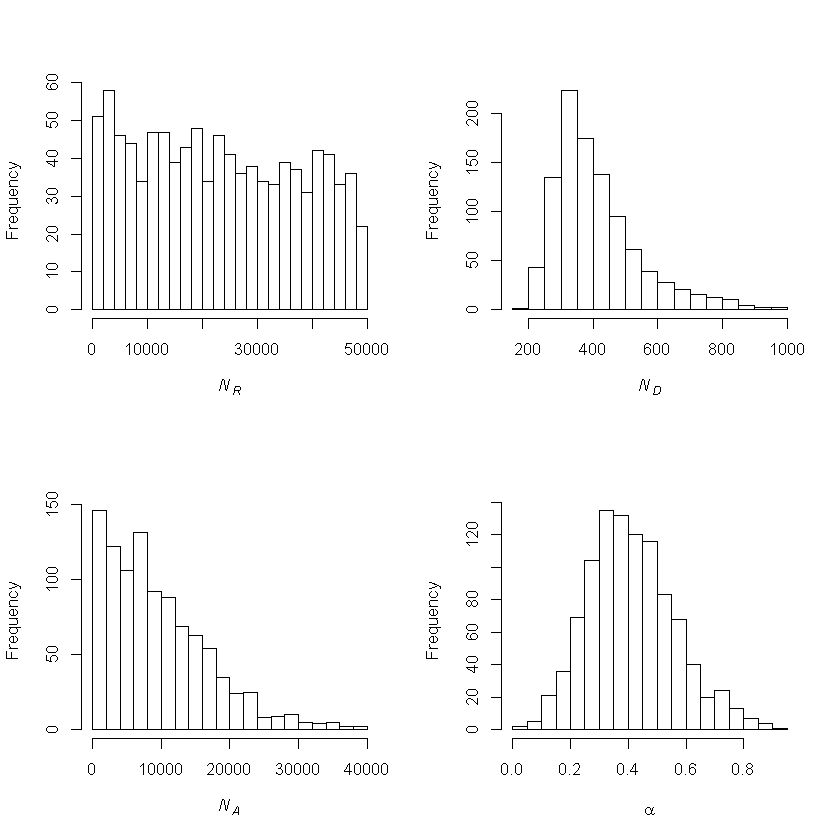

In [44]:
# PLOT POSTERIORS
par(mfrow=c(2,2))
hist(posterior_r, breaks=25, xlab=expression(italic(N['R'])), main='')
hist(posterior_d, breaks=25, xlab=expression(italic(N['D'])), main='')
hist(posterior_a, breaks=25, xlab=expression(italic(N['A'])), main='')
hist(posterior_a/posterior_r, breaks=25, xlab=expression(italic(alpha)), main='')

In [45]:
# SAVE HIGH RES POSTERIOR PLOT
png('fig4_v2.png', height=4800, width=4800, res=300)
par(mfrow=c(2,2), cex=1.5, cex.lab=1.2, cex.axis=1.2, mar=c(5,5,5,5), lwd=3)
hist(posterior_r, breaks=25, xlab=expression(italic(N['R'])), main='')
hist(posterior_d, breaks=25, xlab=expression(italic(N['D'])), main='')
hist(posterior_a, breaks=25, xlab=expression(italic(N['A'])), main='')
hist(posterior_a/posterior_r, breaks=25, xlab=expression(italic(alpha)), main='')
dev.off()

png 
  2

In [27]:
# POSTERIOR STATS
median(posterior_d)
quantile(posterior_d, c(0.025, 0.05, 0.95, 0.975))
median(posterior_a/posterior_r)
quantile(posterior_a/posterior_r, c(0.025, 0.05, 0.95, 0.975))

[1] 270

2.5%      5%     95%   97.5% 
210.975 218.950 297.000 299.000

[1] 0.391486

2.5%        5%       95%     97.5% 
0.1892616 0.2212433 0.5679689 0.6019348

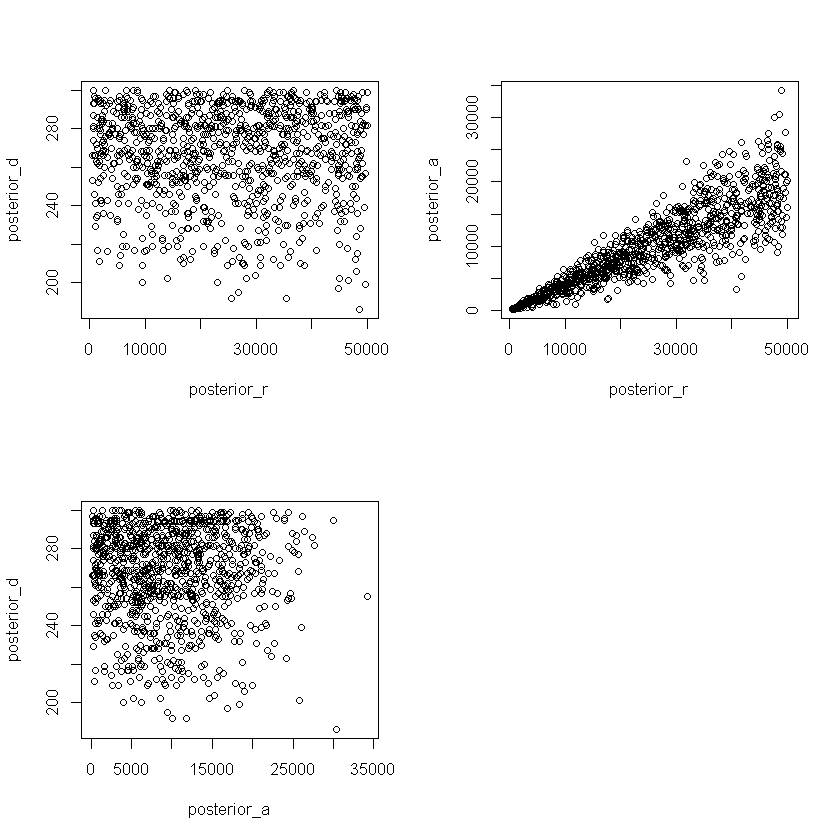

In [28]:
par(mfrow=c(2,2))
plot(posterior_r, posterior_d)
plot(posterior_r, posterior_a)
plot(posterior_a, posterior_d)

#### Example 3
Next I want to try another one with little evidence of aestivation (F-ratio close to 1). For example, (Th09Ma, Th10Ap, Th10Au). We perform exactly the same ABC and hope that the posterior of aestivating size is concentrated in small values. 

In [6]:
# TRY TO RUN A NO AESTIVATION ONE (F-RATIO CLOSE TO 1)
# Th09Ma, Th10Ap, Th10Au
# THE OBSERVED F
obs_F21<-0.068894
obs_F32<-0.003371
obs_F31<-0.066309

# LOCI
K<-433
# EXTRACT ALLELE FREQ
p1<-all_allele_freq[2,]
p2<-all_allele_freq[5,]
p3<-all_allele_freq[7,]
temp<-(p1>=0.05) & (p1<=0.95) & (p2>=0.05) & (p2<=0.95) & (p3>=0.05) & (p3<=0.95)
sum(temp)
# EFF SAMPLE SIZE PER LOCUS
eff_s1<-all_eff_s[2, temp]
eff_s2<-all_eff_s[5, temp]
eff_s3<-all_eff_s[7, temp]
# NUMBER OF GENERATIONS (FOUR YEARS OF BURN IN = 48, START FROM 3RD GEN OF WET)
t1<-t[2]+28
t2<-t[5]+28
t3<-t[7]+28
c(t1, t2, t3)

[1] 433

[1] 37 48 52

In [7]:
# CHECK MONTHS AND SEASONS
temp<-quick_aestivation_sim(N_r=1000, N_d=500, N_a=100, 
                            t_r=5, t_d=7, K=K)
temp$season[c(t1, t2, t3)]
temp$month[c(t1, t2, t3)]
rm(temp)

[1] "dry"   "dry"   "rainy"

[1] 5 4 8

In [8]:
# ABC
cl<-makeCluster(46)
registerDoParallel(cl)
result<-foreach(i=1:200, .combine='rbind', .packages='inline') %dopar%
{
    # BUILD cfunction
    quick_aestivation_sim_c<-cfunction(sig=c(rep_N='array', denom_N='array', aes='array', 
                                         aes_return='array', N_a='numeric', K='integer'), 
                          body=body, includes=includes, 
                          language='C', convention='.Call')
    k<-100000
    out<-1000
    prior_d<-round(runif(k, 10, 300))
    prior_r<-round(runif(k, prior_d+2, 20000))
    prior_a<-round(runif(k, 1, prior_r-prior_d))
    temp_result<-matrix(nc=3, nr=k)
    for (j in 1:k)
    {
        # SIM
        temp<-quick_aestivation_sim2(N_r=prior_r[j], N_d=prior_d[j], N_a=prior_a[j], 
                                    t_r=5, t_d=7, K=K)
        # SAMPLING
        x1<-rbinom(K, size=2*eff_s1, prob=temp[,t1])/(2*eff_s1)
        x2<-rbinom(K, size=2*eff_s2, prob=temp[,t2])/(2*eff_s2)
        x3<-rbinom(K, size=2*eff_s3, prob=temp[,t3])/(2*eff_s3)
        # CALCULATE F
        sim_F21<-mean((x2-x1)^2/((x1+x2)/2-x1*x2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
        sim_F32<-mean((x3-x2)^2/((x3+x2)/2-x3*x2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
        sim_F31<-mean((x3-x1)^2/((x3+x1)/2-x3*x1)-0.5/eff_s1-0.5/eff_s3, na.rm=T)
        temp_result[j,]<-c(sim_F21, sim_F32, sim_F31)
    }
    # CALCULATE DISTANCE
    distance<-sqrt((temp_result[,1]-obs_F21)^2+(temp_result[,2]-obs_F32)^2+(temp_result[,3]-obs_F31)^2)
    temp<-order(distance)[1:out]
    # SHORTLIST
    return(cbind(prior_r[temp], prior_d[temp], prior_a[temp], distance[temp]))
}
stopCluster(cl)
dim(result)

[1] 200000      4

In [9]:
# SAVE ABC RESULTS
save(obs_F21, obs_F32, obs_F31, K, t1, t2, t3, result, file='ABC_ex3.RData')

In [27]:
load('ABC_ex3.RData')

In [28]:
# THEN CALCULATE ANOTHER ROUND OF DISTANCE
temp<-order(result[,4])[1:1000]
posterior_r<-result[temp,1]
posterior_d<-result[temp,2]
posterior_a<-result[temp,3]
max(result[temp,4])
rm(temp)

[1] 0.004773714

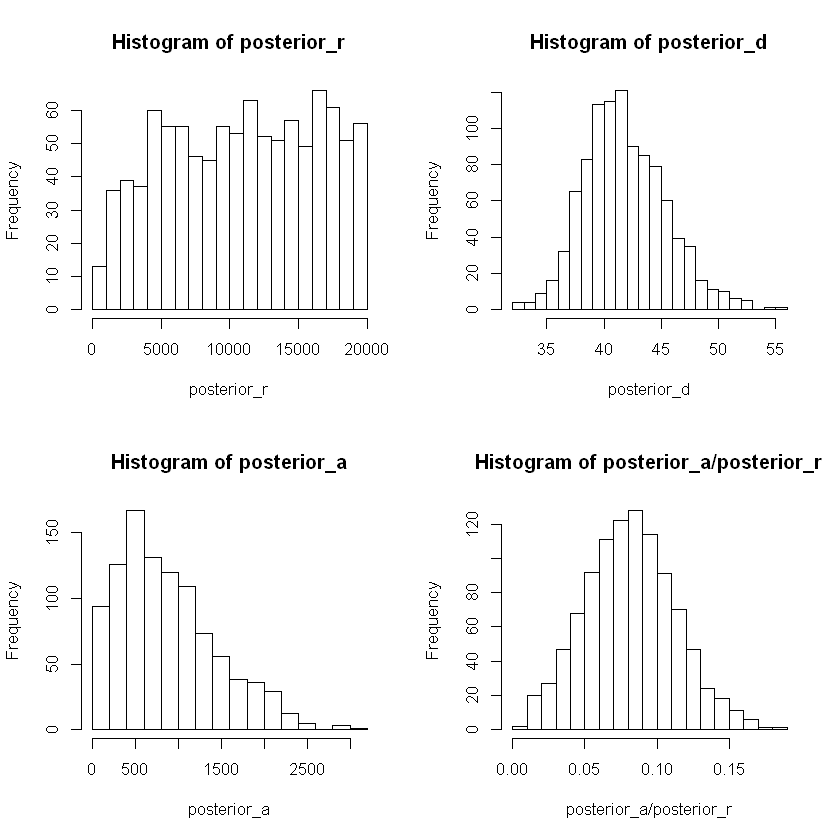

In [29]:
par(mfrow=c(2,2))
hist(posterior_r, breaks=20)
hist(posterior_d, breaks=20)
hist(posterior_a, breaks=20)
hist(posterior_a/posterior_r, breaks=20)

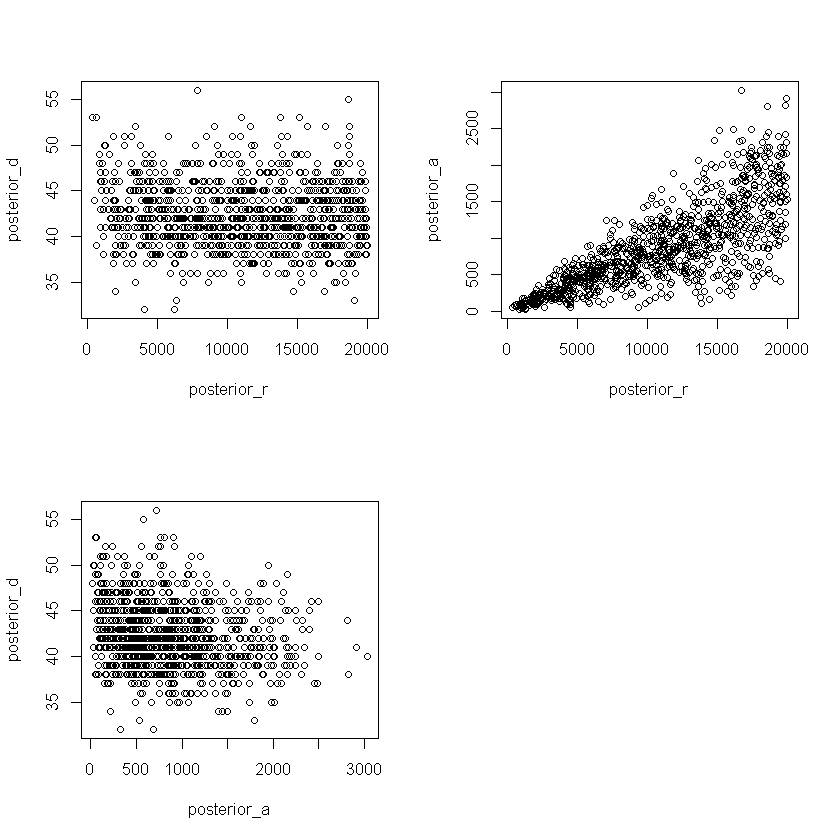

In [13]:
par(mfrow=c(2,2))
plot(posterior_r, posterior_d)
plot(posterior_r, posterior_a)
plot(posterior_a, posterior_d)

#### Example 4 using simulated data

In [10]:
# SAMPLING SIZES AND TIME POINT
eff_s1<-200; eff_s2<-200; eff_s3<-200
t1<-26; t2<-26+6; t3<-26+16
K<-1000
# CHECK MONTHS
m<-quick_aestivation_sim_month(t_r=5, t_d=7)
m$month[c(t1, t2, t3)]
m$season[c(t1, t2, t3)]
# SIMULATE THE OBSERVED DATASET
m<-quick_aestivation_sim(N_r=1000, N_d=100, N_a=400, t_r=5, t_d=7, years=4, K=K)
# SAMPLEING AND OBSERVED F
x1<-rbinom(K, size=2*eff_s1, prob=m[,t1])/(2*eff_s1)
x2<-rbinom(K, size=2*eff_s2, prob=m[,t2])/(2*eff_s2)
x3<-rbinom(K, size=2*eff_s3, prob=m[,t3])/(2*eff_s3)
obs_F21<-mean((x2-x1)^2/((x1+x2)/2-x1*x2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
obs_F32<-mean((x3-x2)^2/((x3+x2)/2-x3*x2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
obs_F31<-mean((x3-x1)^2/((x3+x1)/2-x3*x1)-0.5/eff_s1-0.5/eff_s3, na.rm=T)
# WHAT ARE THEY?
c(obs_F21, obs_F32, obs_F31)
rm(x1); rm(x2); rm(x3); rm(m); 

[1]  6 12 10

[1] "rainy" "dry"   "rainy"

[1] 0.01252947 0.01221800 0.01692793

In [20]:
# ABC
cl<-makeCluster(30)
registerDoParallel(cl)
result<-foreach(i=1:100, .combine='rbind', .packages='inline') %dopar%
{
    setMKLthreads(1)
    # BUILD cfunction
    quick_aestivation_sim_c<-cfunction(sig=c(rep_N='array', denom_N='array', aes='array', 
                                         aes_return='array', N_a='numeric', K='integer'), 
                          body=body, includes=includes, 
                          language='C', convention='.Call')
    k<-10000
    out<-500
    prior_d<-round(runif(k, 10, 300))
    prior_r<-round(runif(k, prior_d+2, 5000))
    prior_a<-round(runif(k, 1, prior_r-prior_d))
    temp_result<-matrix(nc=3, nr=k)
    for (j in 1:k)
    {
        # SIM
        temp<-quick_aestivation_sim2(N_r=prior_r[j], N_d=prior_d[j], N_a=prior_a[j], 
                                    t_r=5, t_d=7, K=K)
        # SAMPLING
        x1<-rbinom(K, size=2*eff_s1, prob=temp[,t1])/(2*eff_s1)
        x2<-rbinom(K, size=2*eff_s2, prob=temp[,t2])/(2*eff_s2)
        x3<-rbinom(K, size=2*eff_s3, prob=temp[,t3])/(2*eff_s3)
        # CALCULATE F
        sim_F21<-mean((x2-x1)^2/((x1+x2)/2-x1*x2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
        sim_F32<-mean((x3-x2)^2/((x3+x2)/2-x3*x2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
        sim_F31<-mean((x3-x1)^2/((x3+x1)/2-x3*x1)-0.5/eff_s1-0.5/eff_s3, na.rm=T)
        temp_result[j,]<-c(sim_F21, sim_F32, sim_F31)
    }
    # CALCULATE DISTANCE
    distance<-sqrt((temp_result[,1]-obs_F21)^2+(temp_result[,2]-obs_F32)^2+(temp_result[,3]-obs_F31)^2)
    temp<-order(distance)[1:out]
    # SHORTLIST
    return(cbind(prior_r[temp], prior_d[temp], prior_a[temp], distance[temp]))
}
stopCluster(cl)
dim(result)

[1] 50000     4

In [25]:
# SAVE ABC RESULTS
save(obs_F21, obs_F32, obs_F31, K, t1, t2, t3, result, file='ABC_ex4.RData')

In [21]:
# THEN CALCULATE ANOTHER ROUND OF DISTANCE
temp<-order(result[,4])[1:1000]
posterior_r<-result[temp,1]
posterior_d<-result[temp,2]
posterior_a<-result[temp,3]
max(result[temp,4])
rm(temp)

[1] 0.1112056

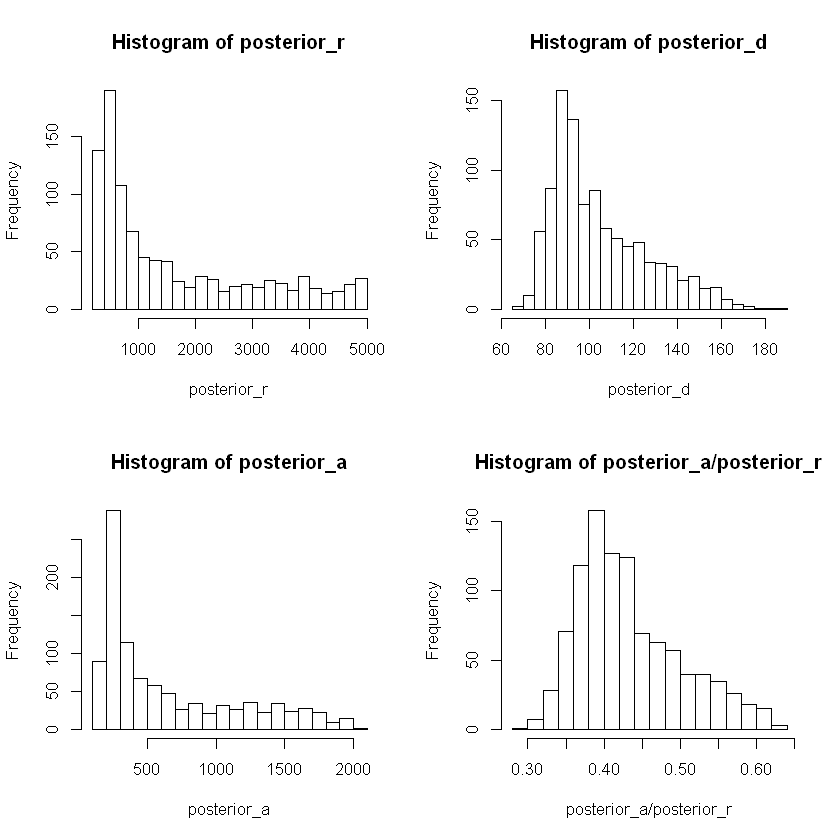

In [22]:
par(mfrow=c(2,2))
hist(posterior_r, breaks=20)
hist(posterior_d, breaks=20)
hist(posterior_a, breaks=20)
hist(posterior_a/posterior_r, breaks=20)

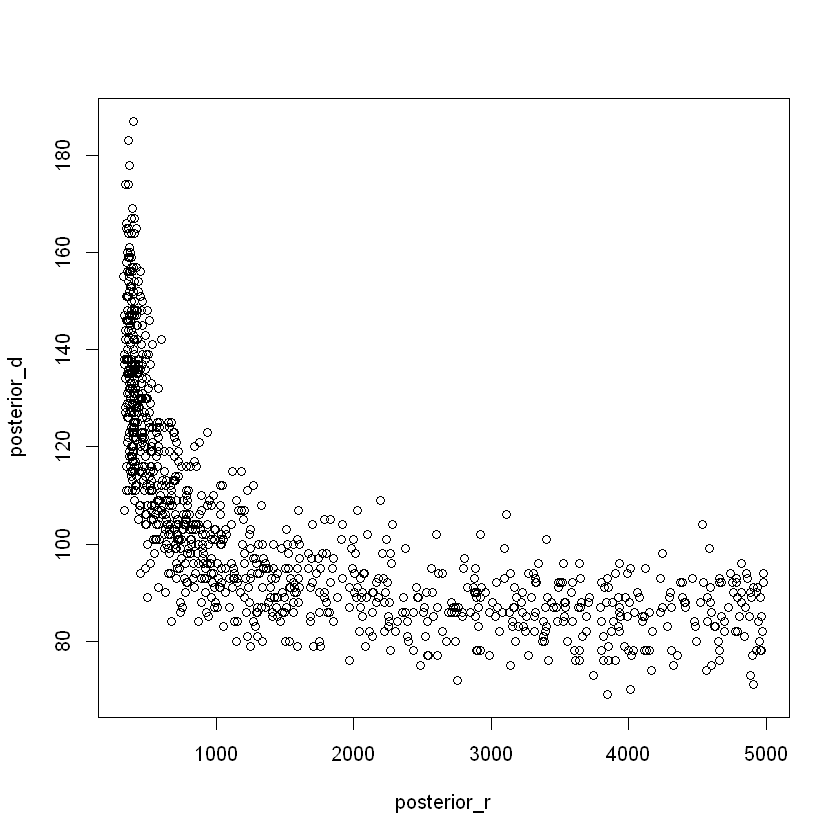

In [23]:
plot(posterior_r, posterior_d)

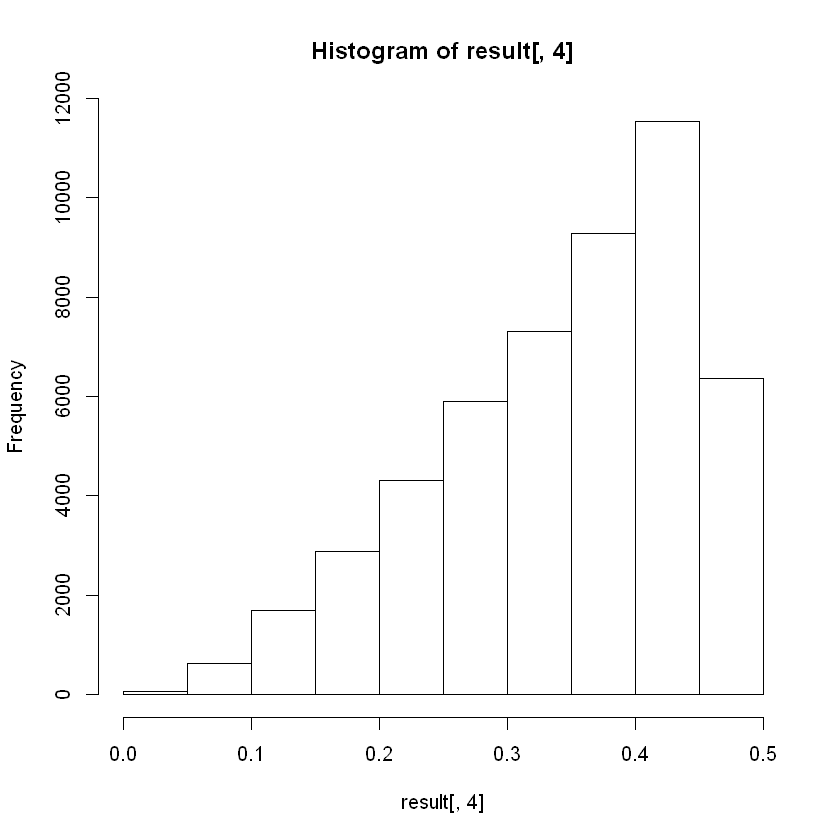

In [24]:
hist(result[,4])

#### Example 5 no aestivation

In [6]:
# SAMPLING SIZES AND TIME POINT
eff_s1<-200; eff_s2<-200; eff_s3<-200
t1<-26; t2<-26+6; t3<-26+16
K<-1000
# CHECK MONTHS
m<-quick_aestivation_sim_month(t_r=5, t_d=7)
m$month[c(t1, t2, t3)]
m$season[c(t1, t2, t3)]
# SIMULATE THE OBSERVED DATASET
m<-quick_aestivation_sim(N_r=1000, N_d=100, N_a=0, t_r=5, t_d=7, years=4, K=K)
# SAMPLEING AND OBSERVED F
x1<-rbinom(K, size=2*eff_s1, prob=m[,t1])/(2*eff_s1)
x2<-rbinom(K, size=2*eff_s2, prob=m[,t2])/(2*eff_s2)
x3<-rbinom(K, size=2*eff_s3, prob=m[,t3])/(2*eff_s3)
obs_F21<-mean((x2-x1)^2/((x1+x2)/2-x1*x2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
obs_F32<-mean((x3-x2)^2/((x3+x2)/2-x3*x2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
obs_F31<-mean((x3-x1)^2/((x3+x1)/2-x3*x1)-0.5/eff_s1-0.5/eff_s3, na.rm=T)
# WHAT ARE THEY?
c(obs_F21, obs_F32, obs_F31)
rm(x1); rm(x2); rm(x3); rm(m);

[1]  6 12 10

[1] "rainy" "dry"   "rainy"

[1] 0.01230701 0.02778523 0.03872473

In [13]:
# ABC
cl<-makeCluster(30)
registerDoParallel(cl)
result<-foreach(i=1:150, .combine='rbind', .packages='inline') %dopar%
{
    setMKLthreads(1)
    # BUILD cfunction
    quick_aestivation_sim_c<-cfunction(sig=c(rep_N='array', denom_N='array', aes='array', 
                                         aes_return='array', N_a='numeric', K='integer'), 
                          body=body, includes=includes, 
                          language='C', convention='.Call')
    k<-10000
    out<-500
    prior_d<-round(runif(k, 10, 300))
    prior_r<-round(runif(k, prior_d+2, 2000))
    prior_a<-round(runif(k, 1, prior_r-prior_d))
    temp_result<-matrix(nc=3, nr=k)
    for (j in 1:k)
    {
        # SIM
        temp<-quick_aestivation_sim2(N_r=prior_r[j], N_d=prior_d[j], N_a=prior_a[j], 
                                    t_r=5, t_d=7, K=K)
        # SAMPLING
        x1<-rbinom(K, size=2*eff_s1, prob=temp[,t1])/(2*eff_s1)
        x2<-rbinom(K, size=2*eff_s2, prob=temp[,t2])/(2*eff_s2)
        x3<-rbinom(K, size=2*eff_s3, prob=temp[,t3])/(2*eff_s3)
        # CALCULATE F
        sim_F21<-mean((x2-x1)^2/((x1+x2)/2-x1*x2)-0.5/eff_s1-0.5/eff_s2, na.rm=T)
        sim_F32<-mean((x3-x2)^2/((x3+x2)/2-x3*x2)-0.5/eff_s3-0.5/eff_s2, na.rm=T)
        sim_F31<-mean((x3-x1)^2/((x3+x1)/2-x3*x1)-0.5/eff_s1-0.5/eff_s3, na.rm=T)
        temp_result[j,]<-c(sim_F21, sim_F32, sim_F31)
    }
    # CALCULATE DISTANCE
    distance<-sqrt((temp_result[,1]-obs_F21)^2+(temp_result[,2]-obs_F32)^2+(temp_result[,3]-obs_F31)^2)
    temp<-order(distance)[1:out]
    # SHORTLIST
    return(cbind(prior_r[temp], prior_d[temp], prior_a[temp], distance[temp]))
}
stopCluster(cl)
dim(result)

[1] 75000     4

In [14]:
# SAVE ABC RESULTS
save(obs_F21, obs_F32, obs_F31, K, t1, t2, t3, result, file='ABC_ex5.RData')

In [18]:
load('ABC_ex5.RData')

In [19]:
# THEN CALCULATE ANOTHER ROUND OF DISTANCE
temp<-order(result[,4])[1:1000]
posterior_r<-result[temp,1]
posterior_d<-result[temp,2]
posterior_a<-result[temp,3]
max(result[temp,4])
rm(temp)

[1] 0.00138225

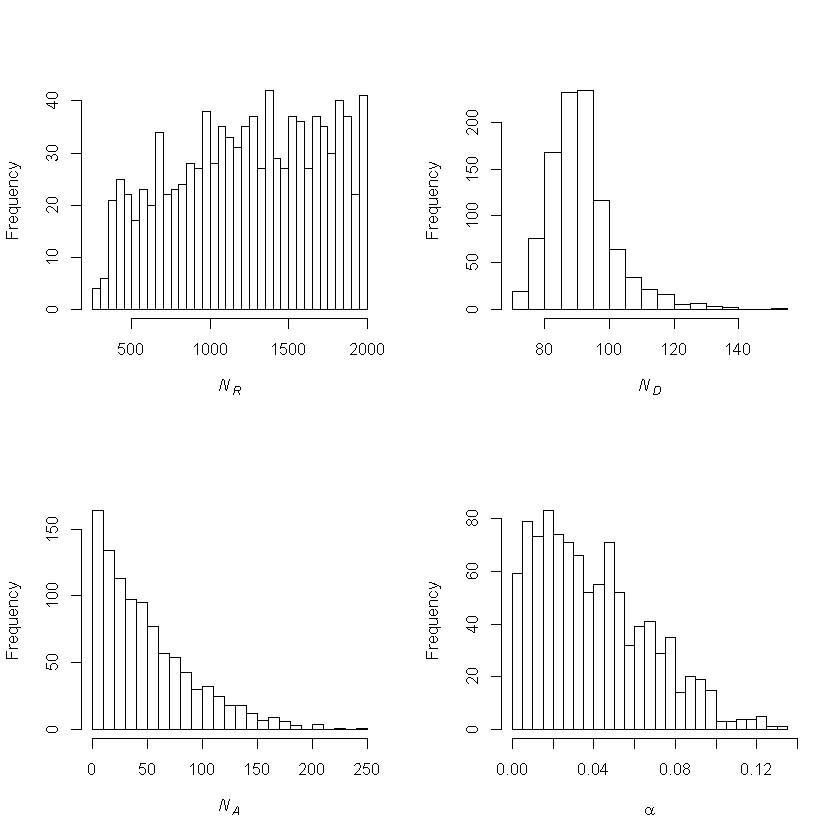

In [20]:
# PLOT POSTERIORS
par(mfrow=c(2,2))
hist(posterior_r, breaks=25, xlab=expression(italic(N['R'])), main='')
hist(posterior_d, breaks=25, xlab=expression(italic(N['D'])), main='')
hist(posterior_a, breaks=25, xlab=expression(italic(N['A'])), main='')
hist(posterior_a/posterior_r, breaks=25, xlab=expression(italic(alpha)), main='')

In [21]:
# SAVE HIGH RES POSTERIOR PLOT
png('fig5.png', height=2400, width=4800, res=300)
par(mfrow=c(1,2), cex=1.5, cex.lab=1.2, cex.axis=1.2, mar=c(5,5,5,5), lwd=3)
hist(posterior_a, breaks=20, xlab=expression(italic(N['A'])), main='')
hist(posterior_a/posterior_r, breaks=20, xlab=expression(italic(alpha)), main='')
dev.off()

png 
  2

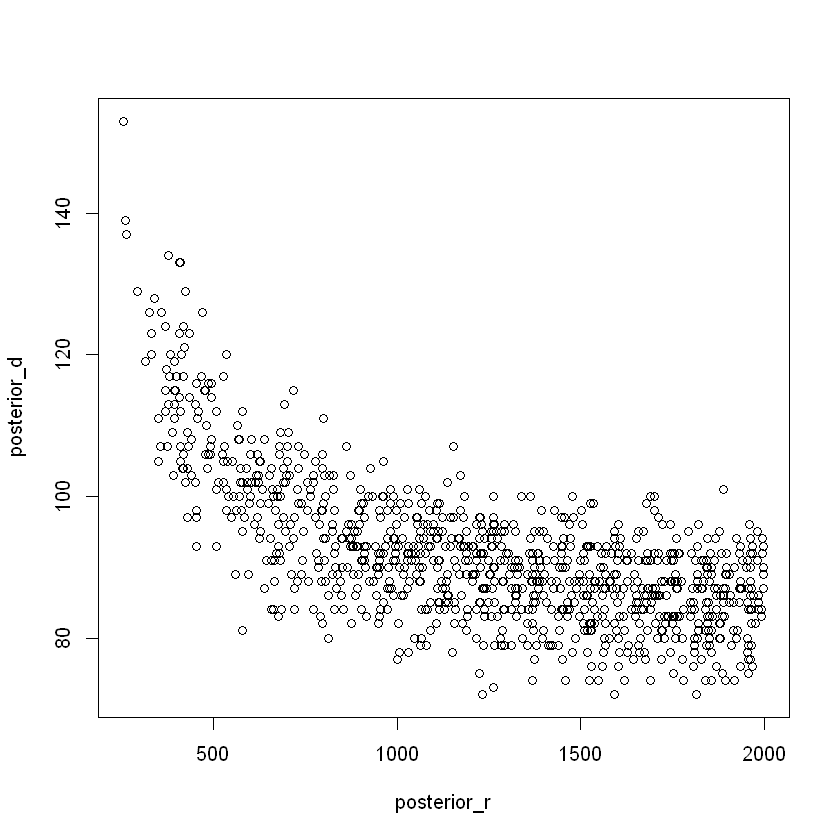

In [17]:
plot(posterior_r, posterior_d)